<a href="https://colab.research.google.com/github/HR-HBM/BME-Code-files/blob/main/DME_Detection_Model_(MobileNetV2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from google.colab import files
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Parameters
IMG_SIZE = 300
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 2  #Positive/Negative

# Data paths
train_dir = "/content/drive/MyDrive/MaculaEdema/train"
test_dir = "/content/drive/MyDrive/MaculaEdema/test"
val_dir = "/content/drive/MyDrive/MaculaEdema/validate"


#class weights
class_weight_dict = {
    0: 1.0,
    1: 10.0
}

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    brightness_range=[0.85, 1.15],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation and test sets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Class weights: {0: 0.5615128844555278, 1: 4.5641891891891895}
Found 2702 images belonging to 2 classes.
Found 579 images belonging to 2 classes.
Found 580 images belonging to 2 classes.


In [ ]:
# Model architecture
def create_dme_model():
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )

    # Freeze early layers
    for layer in base_model.layers[:-20]:
        layer.trainable = False

    # Build the model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )

    return model

# Create the model
model = create_dme_model()
model.summary()

<ipython-input-4-d510a676ac6e>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 10, 10, 1280)   │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 1,370,433 (5.23 MB)

 Non-trainable params: 1,052,160 (4.01 MB)

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint(
    'MobileNetV2_dme_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_auc',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[checkpoint, early_stopping],
    class_weight=class_weight_dict, #class weights
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.5400 - auc: 0.6091 - loss: 1.6644 - precision: 0.1404 - recall: 0.6080 
Epoch 1: val_auc improved from -inf to 0.83272, saving model to MobileNetV2_dme_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 1545s 18s/step - accuracy: 0.5404 - auc: 0.6100 - loss: 1.6624 - precision: 0.1407 - recall: 0.6091 - val_accuracy: 0.8964 - val_auc: 0.8327 - val_loss: 0.2728 - val_precision: 1.0000 - val_recall: 0.0476
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6299 - auc: 0.8488 - loss: 1.0952 - precision: 0.2181 - recall: 0.8733
Epoch 2: val_auc improved from 0.83272 to 0.88241, saving model to MobileNetV2_dme_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.6300 - auc: 0.8488 - loss: 1.0953 - precision: 0.2181 - recall: 0.8734 - val_accuracy: 0.9136 - val_auc: 0.8824 - val_loss: 0.2335 - val_precision: 0.8421 - val_recall: 0.2540
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6585 - auc: 0.8807 - loss: 0.9802 - precision: 0.2463 - recall: 0.8931
Epoch 3: val_auc improved from 0.88241 to 0.91541, saving model to MobileNetV2_dme_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.6584 - auc: 0.8805 - loss: 0.9806 - precision: 0.2460 - recall: 0.8930 - val_accuracy: 0.9188 - val_auc: 0.9154 - val_loss: 0.2493 - val_precision: 0.8636 - val_recall: 0.3016
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6765 - auc: 0.8823 - loss: 0.9862 - precision: 0.2392 - recall: 0.8884
Epoch 4: val_auc improved from 0.91541 to 0.93408, saving model to MobileNetV2_dme_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.6766 - auc: 0.8824 - loss: 0.9857 - precision: 0.2393 - recall: 0.8884 - val_accuracy: 0.9378 - val_auc: 0.9341 - val_loss: 0.1932 - val_precision: 0.8462 - val_recall: 0.5238
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7295 - auc: 0.9118 - loss: 0.8940 - precision: 0.2956 - recall: 0.9067
Epoch 5: val_auc did not improve from 0.93408
85/85 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.7295 - auc: 0.9118 - loss: 0.8934 - precision: 0.2954 - recall: 0.9068 - val_accuracy: 0.9309 - val_auc: 0.9255 - val_loss: 0.2216 - val_precision: 0.8966 - val_recall: 0.4127
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7168 - auc: 0.9242 - loss: 0.7911 - precision: 0.2539 - recall: 0.9527
Epoch 6: val_auc improved from 0.93408 to 0.93846, saving model to MobileNetV2_dme_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.7169 - auc: 0.9241 - loss: 0.7914 - precision: 0.2541 - recall: 0.9523 - val_accuracy: 0.9344 - val_auc: 0.9385 - val_loss: 0.1785 - val_precision: 0.7358 - val_recall: 0.6190
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7603 - auc: 0.9478 - loss: 0.6959 - precision: 0.3192 - recall: 0.9647
Epoch 7: val_auc improved from 0.93846 to 0.94283, saving model to MobileNetV2_dme_model.h5


85/85 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step - accuracy: 0.7603 - auc: 0.9477 - loss: 0.6965 - precision: 0.3190 - recall: 0.9645 - val_accuracy: 0.9430 - val_auc: 0.9428 - val_loss: 0.1767 - val_precision: 0.8947 - val_recall: 0.5397
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7559 - auc: 0.9513 - loss: 0.6685 - precision: 0.2988 - recall: 0.9688
Epoch 8: val_auc did not improve from 0.94283
85/85 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.7561 - auc: 0.9513 - loss: 0.6685 - precision: 0.2990 - recall: 0.9686 - val_accuracy: 0.9240 - val_auc: 0.9303 - val_loss: 0.2199 - val_precision: 0.6338 - val_recall: 0.7143
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7866 - auc: 0.9445 - loss: 0.6826 - precision: 0.3374 - recall: 0.9453
Epoch 9: val_auc did not improve from 0.94283
85/85 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7866 - auc: 0.9445 - loss: 0.6825 - precision: 0.3374 - recall: 0.9452 - val_accuracy: 0.9344 - val_auc: 0.9360 - val_loss: 

85/85 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9049 - auc: 0.9879 - loss: 0.3324 - precision: 0.5546 - recall: 0.9771 - val_accuracy: 0.9378 - val_auc: 0.9445 - val_loss: 0.1844 - val_precision: 0.7288 - val_recall: 0.6825
Epoch 22/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9134 - auc: 0.9883 - loss: 0.3188 - precision: 0.5728 - recall: 0.9818
Epoch 22: val_auc did not improve from 0.94449
85/85 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9134 - auc: 0.9883 - loss: 0.3189 - precision: 0.5726 - recall: 0.9817 - val_accuracy: 0.9344 - val_auc: 0.9302 - val_loss: 0.1927 - val_precision: 0.7273 - val_recall: 0.6349
Epoch 23/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9147 - auc: 0.9881 - loss: 0.3041 - precision: 0.5560 - recall: 0.9796
Epoch 23: val_auc did not improve from 0.94449
85/85 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9148 - auc: 0.9881 - loss: 0.3042 - precision: 0.5563 - recall: 0.9795 - val_accuracy: 0.9344 - val_auc: 0.9417 - val_lo

85/85 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.9590 - auc: 0.9961 - loss: 0.1878 - precision: 0.7301 - recall: 0.9970 - val_accuracy: 0.9465 - val_auc: 0.9597 - val_loss: 0.1722 - val_precision: 0.8077 - val_recall: 0.6667
Epoch 31/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9480 - auc: 0.9946 - loss: 0.2231 - precision: 0.6796 - recall: 0.9877
Epoch 31: val_auc did not improve from 0.95966
85/85 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.9480 - auc: 0.9946 - loss: 0.2231 - precision: 0.6797 - recall: 0.9876 - val_accuracy: 0.9413 - val_auc: 0.9185 - val_loss: 0.2178 - val_precision: 0.8222 - val_recall: 0.5873
Epoch 32/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9577 - auc: 0.9955 - loss: 0.1966 - precision: 0.7394 - recall: 0.9807
Epoch 32: val_auc did not improve from 0.95966
85/85 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9576 - auc: 0.9955 - loss: 0.1966 - precision: 0.7391 - recall: 0.9808 - val_accuracy: 0.9413 - val_auc: 0.9260 - val_lo

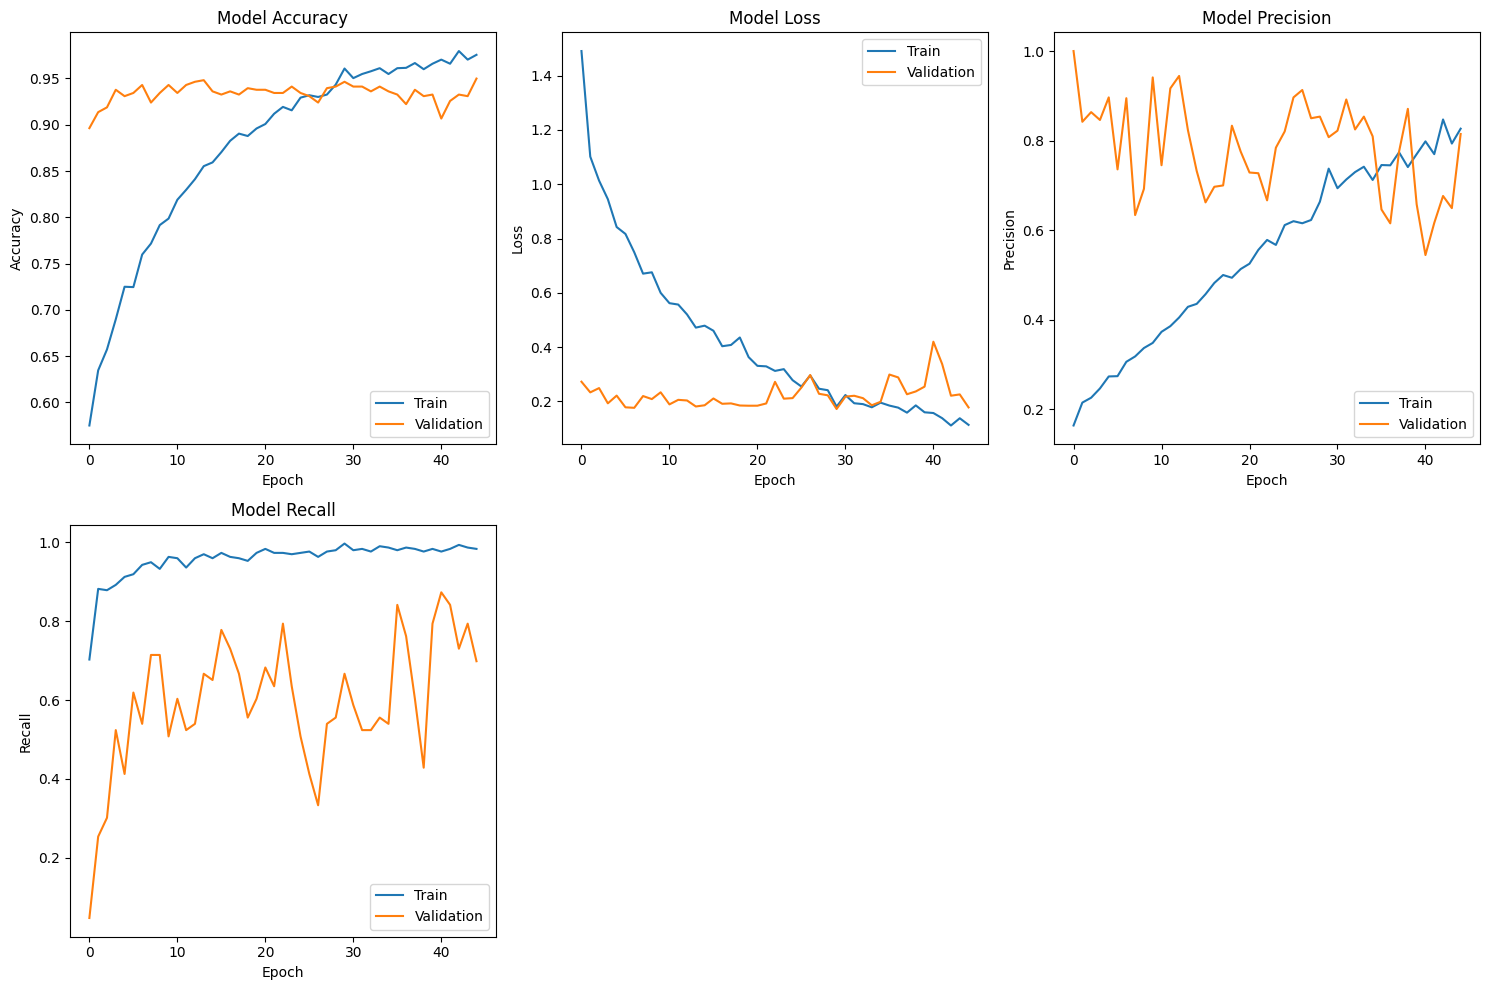

In [ ]:
# Plot training history
plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(2, 3, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='lower right')

plt.subplot(2, 3, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='lower right')



plt.tight_layout()
plt.savefig('dme_training_history.png')
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 245s 14s/step - accuracy: 0.9692 - auc: 0.1758 - loss: 0.1938 - precision: 0.1565 - recall: 0.1177
Test Loss: 0.2628
Test Accuracy: 0.9431
Test Precision: 0.8298
Test Recall: 0.6094
Test AUC: 0.8846
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 932ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.95      0.98      0.97       516
    Positive       0.83      0.61      0.70        64

    accuracy                           0.94       580
   macro avg       0.89      0.80      0.84       580
weighted avg       0.94      0.94      0.94       580



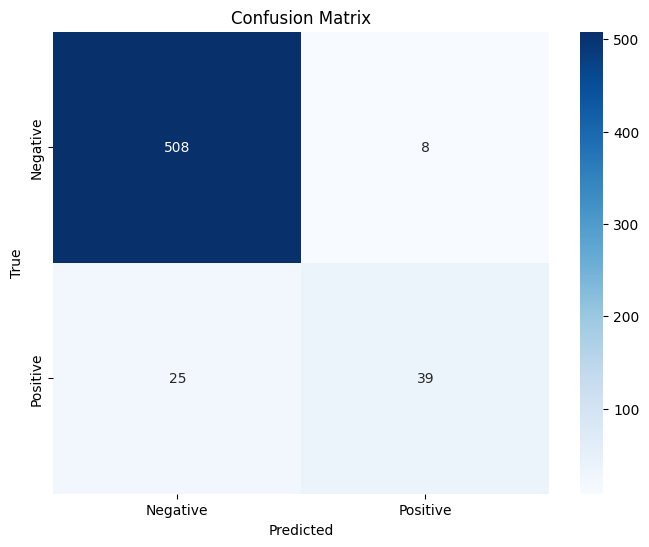

In [ ]:
# Evaluate on test set
test_results = model.evaluate(test_generator)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test Precision: {test_results[2]:.4f}")
print(f"Test Recall: {test_results[3]:.4f}")
print(f"Test AUC: {test_results[4]:.4f}")

# Get predictions
y_pred_prob = model.predict(test_generator)
y_pred_classes = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_generator.classes

# classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Negative', 'Positive']))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('dme_confusion_matrix.png')
plt.show()



In [ ]:
#load model
best_model = tf.keras.models.load_model('MobileNetV2_dme_model.h5')

# Download model
files.download('MobileNetV2_dme_model.h5')

# TFLite conversion of the model
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the TFLite model
with open('MobileNetV2_dme_model.tflite', 'wb') as f:
    f.write(tflite_model)

# Download the TFLite model
files.download('MobileNetV2_dme_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saved artifact at '/tmp/tmptm4nrwv2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139410060160720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410058820880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409540250896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410058821072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139410058821456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409540247248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409540248592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409540250512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409540249744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139409540246480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1394095402507

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>